**Implementacija predikcije ocene parfema uz koriscenje XGBoost i Random Forest**

Pre svega treba importovati sve potrebne pakete koji ce nam sluziti za analizu.

In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re
from ast import literal_eval
import matplotlib.pyplot as plt


Funckija *parse_season_ratings* sluzi za za parsiranje polja godisnja doba iz skupa podataka, dok funckija *consolidate_notes* objedinjuje/konsoliduje base, middle i top note u jednu kolekciju

In [91]:
def parse_season_ratings(rating_str):
    pattern = r'([A-Za-z]+):\s*([0-9.]+)%'
    return {season: float(percent) for season, percent in re.findall(pattern, rating_str)}

def consolidate_notes(notes):
    all_notes = []
    for note_type in ['Top Notes', 'Middle Notes', 'Base Notes']:
        if note_type in notes:
            all_notes.extend(notes[note_type])
    return all_notes


Ucitavanje skupa podataka

In [92]:
file_path = "../datasets/mainDataset.csv"  
data = pd.read_csv(file_path, delimiter='|')

Prasiranje nekih relevantnih polja iz skupa podataka, zbog njihovog oblika cuvanja u dataset, koji ce biti ulaz u algoritme. Koristila se metoda literal_Eval za bezbedno parsiranje stringova koji predstavljaju Python literale u stvarne Python objekte.

In [93]:
data['Accords'] = data['Accords'].apply(literal_eval)
data['Notes'] = data['Notes'].apply(literal_eval)
data['Votes'] = data['Rating'].apply(lambda x: literal_eval(x)['votes'])
data['Rating'] = data['Rating'].apply(lambda x: literal_eval(x)['rating'])
data['Season ratings'] = data['Season ratings'].apply(parse_season_ratings)
data['Day ratings'] = data['Day ratings'].apply(parse_season_ratings)
data['Designers'] = data['Designers'].apply(literal_eval)


Izdvajanje relevantnih polja i stvaranje recorda i formiranje Data Frame koji sadrzi svaki parfem iz skupa podataka u pogodnom obliku. URL slike parfma i tekstualni opis nisu bili releventni za eksperiment, kao i samo ime parfema.

In [94]:
records = []
for _, row in data.iterrows():
    records.append({
        "Brand": row["Brand"],
        "Accords": row["Accords"],
        "Gender": row["Gender"],
        "Longevity": row["Longevity"],
        "Sillage": row["Sillage"],
        "Rating": row["Rating"],
        "Votes" : row["Votes"],
        "Season_Winter": row["Season ratings"].get("Winter", 0),
        "Season_Spring": row["Season ratings"].get("Spring", 0),
        "Season_Summer": row["Season ratings"].get("Summer", 0),
        "Season_Fall": row["Season ratings"].get("Fall", 0),
        "Day": row["Day ratings"].get("Day", 0),
        "Night": row["Day ratings"].get("Night", 0)
    })

Formiranje DataFrame-a i dodavanje obelezja koji cini sve note jednog parfema (note nisu razlozene po base, middle i top notes). 
Takodje je izvresen i eksperiment gde je iz celije ispod uklonjeno (apply(consolidate_notes)), rezultati za MAE I RMSE bili malo losiji (MAE je bilo veci za 0.005), ali R^2 je bio malo bolji (manj za 0.02) jer jer sad model zna nešto o hemiji/parfemskoj kompoziciji. Zakljuceno je da model lakše uči koje kombinacije nota se češće povezuju sa višim (ili nižim) ocenama. Model uči samo prisustvo/odsustvo nota, a ne i njihovu hijerarhiju. To je kompromis: jednostavnija reprezentacija → jasniji signal, ali manje detalja.

In [95]:
structured_df = pd.DataFrame(records)
structured_df['All Notes'] = data['Notes'].apply(consolidate_notes)


Kategorijske kolone Brand i Gender su pretvorene u one-hot enkodirane kolone, dok su sve jedinstvene note iz All Notes pretvorene u binarne indikatorske kolone koje pokazuju prisustvo svake note, kao i akordi.

In [96]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = pd.DataFrame(
    ohe.fit_transform(structured_df[['Brand', 'Gender']]),
    columns=ohe.get_feature_names_out(['Brand', 'Gender'])
)

all_unique_notes = set(note for notes in structured_df['All Notes'] for note in notes)
note_df = pd.DataFrame(
    {f'Note_{note}': structured_df['All Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_notes}
)

all_unique_accords = set(accord for accords in structured_df['Accords'] for accord in accords)
accord_df = pd.DataFrame(
    {f'Accord_{accord}': structured_df['Accords'].apply(lambda x: 1 if accord in x else 0)
     for accord in all_unique_accords}
)

structured_df = pd.concat([structured_df, note_df, accord_df], axis=1)

X = pd.concat([ohe_features, structured_df.drop(columns=['Brand', 'Gender', 'Rating', 'All Notes', 'Accords'])], axis=1)
y = structured_df['Rating']


In [97]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [85]:

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Random Forest R^2:", rf_model.score(X_test, y_test))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Random Forest R^2: 0.38510803893853895
Random Forest MAE: 0.1513336814621409
Random Forest RMSE: 0.1962264971208622


In [86]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
#top_features = importances.sort_values(ascending=False).head(30)
#print(top_features)
#plt.figure(figsize=(10,6))
#top_features.plot(kind="barh")
#plt.title("Top 20 Feature Importances - Random Forest")
#plt.gca().invert_yaxis()
#plt.show()

Uradjen je feature importance za Randon Forest iz kojeg se moze videti da su najvaznija obelezja zapravo note, karakteristika parfema kojem godisnjem dobu pripada je takodje zajedno sa njegovom dugotrajnoscu jos jedna istaknuta i bitna karakteristika. Finalno brend, broj glasova (odnsno popularnost), akordi imaju znacaj ali manji u odnsou na prethodno navedene karakteristike. Moze se uvideti da  vaznost karakteristike koliko je parfem za noc ili dan ima znacaja ali nije previse relevantna (manje od 10%). Karakteristika Sillage koja zapravo opisuje mirisni trag odnosno auru parfema nije bila mnogo znacajna. A najmanje znacajna karaktersitika je Gender, sto nam prikazuje da ni jedna kategorija tog obelezja nepreovladava i da parfemi iako su potekli sa karakteristikom muski/zenski da sve manje ta karakteristika ima uticaj i znacanje, vec parfem sluzi da opise zamisljeni osecaj, nego da bude prikladan odredjenom polu. Takodje u poslednjih nekoliko godina sve vise unisex parfema se kreira.

Ukupna važnost Brand: 0.1086533000734435
Ukupna važnost Gender: 0.024110335697178898
Ukupna važnost Notes: 0.2303144561946555
Ukupna važnost Season: 0.1530992242859622
Ukupna važnost Day/Night: 0.08722180347845152
Važnost Longevity: 0.14398194507627513
Važnost Sillage: 0.03341814130104291
Važnost Votes: 0.11083045330984331
Brand        0.108653
Gender       0.024110
Notes        0.230314
Season       0.153099
Day/Night    0.087222
Longevity    0.143982
Sillage      0.033418
Votes        0.110830
Accords      0.108370
dtype: float64


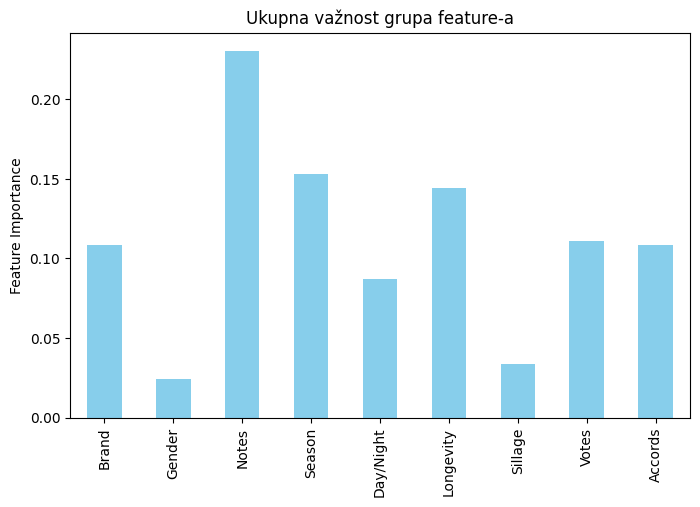

In [74]:
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
gender_importance = importances[importances.index.str.startswith("Gender_")].sum()
notes_importance = importances[importances.index.str.startswith("Note_")].sum()
season_importance = importances[importances.index.str.startswith("Season_")].sum()
day_night_importance = importances[importances.index.str.startswith("Day") | importances.index.str.startswith("Night")].sum()
longevity_importance = importances["Longevity"]
sillage_importance = importances["Sillage"]
votes_importance = importances["Votes"]
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Gender:", gender_importance)
print("Ukupna važnost Notes:", notes_importance)
print("Ukupna važnost Season:", season_importance)
print("Ukupna važnost Day/Night:", day_night_importance)
print("Važnost Longevity:", longevity_importance)
print("Važnost Sillage:", sillage_importance)
print("Važnost Votes:", votes_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Gender": gender_importance,
    "Notes": notes_importance,
    "Season": season_importance,
    "Day/Night": day_night_importance,
    "Longevity": longevity_importance,
    "Sillage": sillage_importance,
    "Votes": votes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()

In [98]:

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)

print("XGBoost R^2:", xgb_model.score(X_test, y_test))
print("XGBoost MAE:", mean_absolute_error(y_test, y_xgb_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_xgb_pred)))


XGBoost R^2: 0.2792446449587108
XGBoost MAE: 0.1631534051770641
XGBoost RMSE: 0.21244777280037297


Nakon uradjenog feature importance sa istim vrednostima kao za xgboost, moze se primertii da polja koja su bila releventna kod random forest, uopste nisu relevantna za xgboost. Jedina relevantna polja su Notes, Brand i Accords.

Ukupna važnost Brand: 0.27935246
Ukupna važnost Gender: 0.017788015
Ukupna važnost Notes: 0.49325663
Ukupna važnost Season: 0.0197994
Ukupna važnost Day/Night: 0.011299353
Važnost Longevity: 0.006218395
Važnost Sillage: 0.0024645892
Važnost Votes: 0.0075986865
Brand        0.279352
Gender       0.017788
Notes        0.493257
Season       0.019799
Day/Night    0.011299
Longevity    0.006218
Sillage      0.002465
Votes        0.007599
Accords      0.162223
dtype: float32


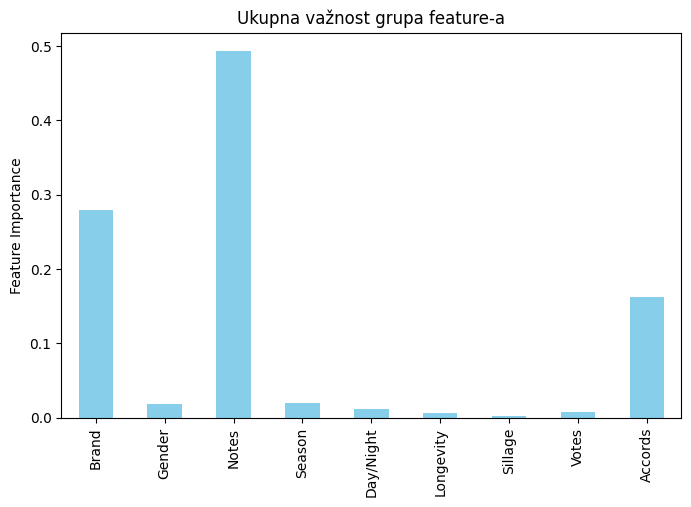

In [99]:
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
gender_importance = importances[importances.index.str.startswith("Gender_")].sum()
notes_importance = importances[importances.index.str.startswith("Note_")].sum()
season_importance = importances[importances.index.str.startswith("Season_")].sum()
day_night_importance = importances[importances.index.str.startswith("Day") | importances.index.str.startswith("Night")].sum()
longevity_importance = importances["Longevity"]
sillage_importance = importances["Sillage"]
votes_importance = importances["Votes"]
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Gender:", gender_importance)
print("Ukupna važnost Notes:", notes_importance)
print("Ukupna važnost Season:", season_importance)
print("Ukupna važnost Day/Night:", day_night_importance)
print("Važnost Longevity:", longevity_importance)
print("Važnost Sillage:", sillage_importance)
print("Važnost Votes:", votes_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Gender": gender_importance,
    "Notes": notes_importance,
    "Season": season_importance,
    "Day/Night": day_night_importance,
    "Longevity": longevity_importance,
    "Sillage": sillage_importance,
    "Votes": votes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()

Probali smo da uklonimo karakteristike koje se nisu pokazale kao bitne, ali dobili smo MAE losiji za 0.01

In [112]:
recordsForXGB = []
for _, row in data.iterrows():
    recordsForXGB.append({
        "Brand": row["Brand"],
        "Accords": row["Accords"],
        "Rating": row["Rating"]
    })

In [113]:
structured_df_XGB = pd.DataFrame(recordsForXGB)
structured_df_XGB['All Notes'] = data['Notes'].apply(consolidate_notes)

In [114]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = pd.DataFrame(
    ohe.fit_transform(structured_df_XGB[['Brand']]),
    columns=ohe.get_feature_names_out(['Brand'])
)

all_unique_notes = set(note for notes in structured_df_XGB['All Notes'] for note in notes)
note_df = pd.DataFrame(
    {f'Note_{note}': structured_df_XGB['All Notes'].apply(lambda x: 1 if note in x else 0)
     for note in all_unique_notes}
)

all_unique_accords = set(accord for accords in structured_df_XGB['Accords'] for accord in accords)
accord_df = pd.DataFrame(
    {f'Accord_{accord}': structured_df_XGB['Accords'].apply(lambda x: 1 if accord in x else 0)
     for accord in all_unique_accords}
)

structured_df_XGB = pd.concat([structured_df_XGB, note_df, accord_df], axis=1)

X = pd.concat([ohe_features, structured_df_XGB.drop(columns=['Brand', 'Rating', 'All Notes', 'Accords'])], axis=1)
y = structured_df_XGB['Rating']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
xgb_model_novo = XGBRegressor(random_state=42)
xgb_model_novo.fit(X_train, y_train)
y_xgb_pred = xgb_model_novo.predict(X_test)

print("XGBoost R^2:", xgb_model_novo.score(X_test, y_test))
print("XGBoost MAE:", mean_absolute_error(y_test, y_xgb_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_xgb_pred)))

XGBoost R^2: 0.20548582216108846
XGBoost MAE: 0.17244735209811138
XGBoost RMSE: 0.22305351390636316


Ukupna važnost Brand: 0.2848767
Ukupna važnost Notes: 0.55551285
Ukupna važnost Notes: 0.15961044
Brand      0.284877
Notes      0.555513
Accords    0.159610
dtype: float32


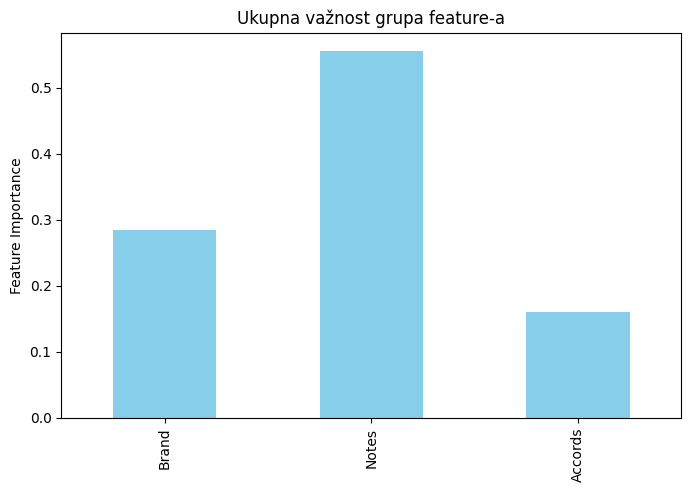

In [119]:
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
brand_importance = importances[importances.index.str.startswith("Brand_")].sum()
notes_importance = importances[importances.index.str.startswith("Note_")].sum()
accords_importance = importances[importances.index.str.startswith("Accord_")].sum()

print("Ukupna važnost Brand:", brand_importance)
print("Ukupna važnost Notes:", notes_importance)
print("Ukupna važnost Notes:", accords_importance)

group_importances = pd.Series({
    "Brand": brand_importance,
    "Notes": notes_importance,
    "Accords" : accords_importance
})

# Print rezultata
print(group_importances)

# Vizualizacija
plt.figure(figsize=(8,5))
group_importances.plot(kind="bar", color="skyblue")
plt.title("Ukupna važnost grupa feature-a")
plt.ylabel("Feature Importance")
plt.show()